In [2]:
import numpy as np
import pandas as pd
import string
from collections import Counter
import torch
from torch import nn, optim
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torch.nn.functional import softmax

In [3]:
df = pd.read_csv("/home/murad/english_cleaned_lyrics.csv", dtype=str)
df = df[df['genre']=='Pop'][:100]
df.drop(df.columns[df.columns.str.contains('unnamed',case = False)],axis = 1, inplace = True)

In [4]:
df

,index,song,year,artist,genre,lyrics
0,0,ego-remix,2009,beyonce-knowles,Pop,Oh baby how you doing You know I'm gonna cut r...
1,1,then-tell-me,2009,beyonce-knowles,Pop,playin everything so easy it's like you seem s...
2,2,honesty,2009,beyonce-knowles,Pop,If you search For tenderness It isn't hard to ...
3,3,you-are-my-rock,2009,beyonce-knowles,Pop,Oh oh oh I oh oh oh I If I wrote a book about ...
4,4,black-culture,2009,beyonce-knowles,Pop,Party the people the people the party it's pop...
...,...,...,...,...,...,...
95,109,creole-japan-bonus-track,2006,beyonce-knowles,Pop,Baby I see you That look in your eyes Hips tha...
96,110,he-s-my-man,2006,beyonce-knowles,Pop,Beyonce you can do so much better You say that...
97,111,in-da-club-remix,2006,beyonce-knowles,Pop,No shorty it's Beyonce We gon party like it's ...
98,112,kitty-kat,2006,beyonce-knowles,Pop,You know I hate sleepin alone But you said tha...


In [11]:
class LyricsDataset(Dataset):
    def __init__(self, batch_size):

        self.words = self.load_words()
        self.unique_words = self.get_unique_words()

        self.idx_to_word = {idx: word for idx, word in enumerate(self.unique_words)}
        self.word_to_idx = {word: idx for idx, word in enumerate(self.unique_words)}

        self.words_idxes = [self.word_to_idx[w] for w in self.words]

        self.batch_size = batch_size

    def load_words(self):
        train_df = pd.read_csv("/home/murad/english_cleaned_lyrics.csv", dtype=str)
        train_df = train_df[train_df['genre']=='Pop'][:100]
        #text = train_df['lyrics'].str.replace('[{}]'.format(string.punctuation), ' ').str.cat(sep=' ').lower().replace('  ',' ')
        text = train_df['lyrics'].str.cat(sep=' ').lower().replace('  ',' ')
        return text.split(' ')

    def get_unique_words(self):
        word_counts = Counter(self.words)
        return sorted(word_counts, key=word_counts.get, reverse=True)

    def __len__(self):
        return len(self.words_idxes)-self.batch_size  

    def __getitem__(self, idx):
        return (
            torch.tensor(self.words_idxes[idx:idx+self.batch_size]),
            torch.tensor(self.words_idxes[idx+1:idx+self.batch_size+1]),
        )

In [13]:
class LSTMModel(nn.Module):
    def __init__(self, dataset):
        super(LSTMModel, self).__init__()
        self.hidden_size = 128
        self.embedding_dim = 128
        self.num_layers = 3
        self.output_size = len(dataset.unique_words) # vocab_size

        self.encoder = nn.Embedding(
            num_embeddings=self.output_size, 
            embedding_dim=self.embedding_dim,
        )
        self.lstm = nn.LSTM(
            input_size=self.embedding_dim,
            hidden_size=self.hidden_size,
            num_layers=self.num_layers,
            dropout=0.2,
        )
        self.decoder= nn.Linear(self.hidden_size, self.output_size) #(hidden_size, output_size)

    def forward(self, input, prev_state):
        embed = self.encoder(input)
        lstm_out, state = self.lstm(embed, prev_state)
        out = self.decoder(lstm_out)

        return out, state

    def init_state(self, batch_size):
        return (torch.zeros(self.num_layers, batch_size, self.hidden_size), # (layers, batch_size, hidden_size)
                torch.zeros(self.num_layers, batch_size, self.hidden_size))

In [14]:
def save_metrices(save_path, train_loss, train_accuracy, steps):
   state_dict = { 'loss' : train_loss,
                 'accuracy' : train_accuracy,
                 'epoch' : steps}

   torch.save(state_dict, save_path)
   print(f'Model saved to ==> {save_path}')

def load_metrices(load_path):
   state_dict = torch.load(load_path)
   print(f'Model loaded from ==> {load_path}')
   return state_dict['loss'], state_dict['accuracy'], state_dict['epoch']


In [15]:
def train(dataset, model, batch_size):
    model.train()  #the model knows it has to learn the layers

    dataloader = DataLoader(
        dataset,
        batch_size=128,
    )

    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    
    loss_list = []
    accuracy_list =[]
    epoch_list = []

    for epoch in range(150):
        hidden_state, cell_state = model.init_state(batch_size)
        
        step =0
        loss_sum=0.0
        accuracy_sum=0.0
        
        for batch, (inp, lab) in enumerate(dataloader):
            optimizer.zero_grad()
            correct_train=0
            total_train=0
            out_pred, (hidden_state, cell_state) = model(inp, (hidden_state, cell_state))
            
            loss = criterion(out_pred.transpose(1, 2), lab) 

            hidden_state = hidden_state.detach()  # detach to stop back propagating
            cell_state = cell_state.detach()

            loss.backward()
            optimizer.step()
           
            _, predicted = torch.max(out_pred.transpose(1, 2), 1) 
            total_train += lab.nelement()
            correct_train += predicted.eq(lab).float().sum().item()
            accuracy = correct_train / total_train
            
            step+=1
            loss_sum+= loss.item()
            accuracy_sum+=accuracy


        avg_loss = loss_sum/step
        avg_accuracy = accuracy_sum/step 
        loss_list.append(avg_loss)
        accuracy_list.append(avg_accuracy)
        epoch_list.append(epoch+1)
        print({ 'epoch': epoch+1, 'loss': avg_loss , 'accuracy': avg_accuracy })
    
    save_metrices('/home/murad/metrics.pt', loss_list, accuracy_list, epoch_list)    

In [16]:
def predict(dataset, model, text, next_words=100):
    words = text.split(' ')
    model.eval()   #the model is used for testing


    hidden_state, cell_state = model.init_state(len(words))

    for i in range(0, next_words):
        inp = torch.tensor([[dataset.word_to_idx[w] for w in words[i:]]])
        out_pred, (hidden_state, cell_state) = model(inp, (hidden_state, cell_state))

        last_word_outs = out_pred[0][-1]
        p = softmax(last_word_outs, dim=0).detach().numpy()
        word_idx = np.random.choice(len(last_word_outs), p=p)
        words.append(dataset.idx_to_word[word_idx])

    return words

In [17]:
batch_size = 4  #length of the sequence of words chosen for training. 
dataset = LyricsDataset(batch_size)
model = LSTMModel(dataset)

train(dataset, model, batch_size)

{'epoch': 1, 'loss': 6.371757369713495, 'accuracy': 0.04755007340604027}
{'epoch': 2, 'loss': 6.030858404684387, 'accuracy': 0.052636063338926176}
{'epoch': 3, 'loss': 5.887264155701503, 'accuracy': 0.05243288590604027}
{'epoch': 4, 'loss': 5.721387880760552, 'accuracy': 0.05486446098993288}
{'epoch': 5, 'loss': 5.535872685829265, 'accuracy': 0.05954409605704698}
{'epoch': 6, 'loss': 5.3494585416461, 'accuracy': 0.06575739303691275}
{'epoch': 7, 'loss': 5.167357889597848, 'accuracy': 0.07374685402684564}
{'epoch': 8, 'loss': 5.014340057469054, 'accuracy': 0.08074664429530201}
{'epoch': 9, 'loss': 4.849060463425297, 'accuracy': 0.09186241610738255}
{'epoch': 10, 'loss': 4.708217567245432, 'accuracy': 0.1059209836409396}
{'epoch': 11, 'loss': 4.563145531103915, 'accuracy': 0.12041212248322147}
{'epoch': 12, 'loss': 4.417766363028712, 'accuracy': 0.138671875}
{'epoch': 13, 'loss': 4.281385301743578, 'accuracy': 0.15914036283557048}
{'epoch': 14, 'loss': 4.148006527215842, 'accuracy': 0.18

In [18]:
import matplotlib.pyplot as plt
def plot_graph(epochs, data_list, ylabel):
  plt.plot(epochs, data_list, label ='Train')
  plt.xlabel('Epochs')
  plt.ylabel(ylabel)
  plt.legend()
  plt.show()

Model loaded from ==> /home/murad/metrics.pt


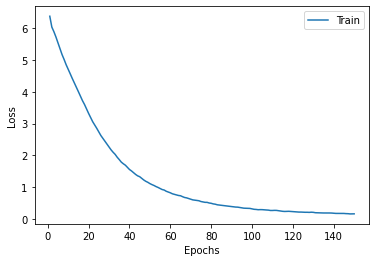

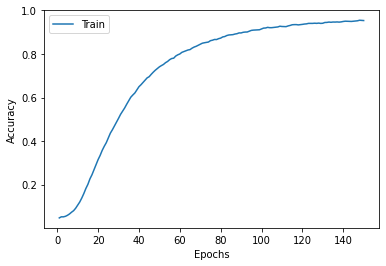

In [19]:
loss_list,accuracy_list, epochs = load_metrices('/home/murad/metrics.pt')

plot_graph(epochs, loss_list, 'Loss')
plot_graph(epochs, accuracy_list, 'Accuracy')

In [24]:

print(' '.join(predict(dataset, model, text='i\'m here for you')))

i'm here for you doing you know i'm gonna cut right to the chase some women were made but me myself i like to think that i was created for a special purpose you know what's more special than you you feel me it's on baby let's get lost you don't need to call into work cause you're the boss for real want you to show me how you feel i consider myself lucky that's a big deal why well you got the key to my heart but you ain't gonna need it i'd rather you open up my body and show me secrets
